# Marketing Analytics Pipeline - Business Analysis Dashboard

This notebook demonstrates how to analyze the output of the marketing analytics pipeline using pandas and matplotlib.

## Pipeline Overview
The pipeline creates several business analysis tables:
- **monthly_metrics**: Revenue, customer, and transaction trends by month
- **cohort_analysis**: Customer retention analysis by acquisition cohort
- **customer_ltv_analysis**: Customer lifetime value and churn risk scoring
- **campaign_targets**: Customers ready for marketing campaigns
- **business_insights**: Automated insights and recommendations

## Prerequisites
Make sure you've run the pipeline first:
```bash
python pipeline/master_pipeline.py data/raw/HEC_testing_data_sample_2_.csv
```


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📊 Marketing Analytics Dashboard - Setup Complete")
print("=" * 55)

📊 Marketing Analytics Dashboard - Setup Complete


## 1. Connect to Business Database

In [22]:
# Connect to the business analysis database
try:
    business_conn = sqlite3.connect('../data/business.db')
    print("✅ Connected to ../data/business.db")
    
    # List all tables
    tables = pd.read_sql_query("""
        SELECT name FROM sqlite_master 
        WHERE type='table' AND name NOT LIKE 'sqlite_%'
        ORDER BY name
    """, business_conn)
    
    print(f"\n📋 Available Analysis Tables ({len(tables)} total):")
    for table in tables['name']:
        count_query = f"SELECT COUNT(*) as count FROM {table}"
        count = pd.read_sql_query(count_query, business_conn)['count'].iloc[0]
        print(f"   • {table}: {count:,} rows")
        
except Exception as e:
    print(f"❌ Error connecting to business database: {e}")
    print("💡 Make sure you've run the pipeline first!")
    print("📋 Run: python run_pipeline.py")

✅ Connected to ../data/business.db

📋 Available Analysis Tables (5 total):
   • business_insights: 3 rows
   • campaign_targets: 28,753 rows
   • cohort_analysis: 276 rows
   • customer_ltv_analysis: 33,477 rows
   • monthly_metrics: 23 rows


## 2. Monthly Revenue and Customer Trends

📈 Monthly Metrics Analysis (23 months)


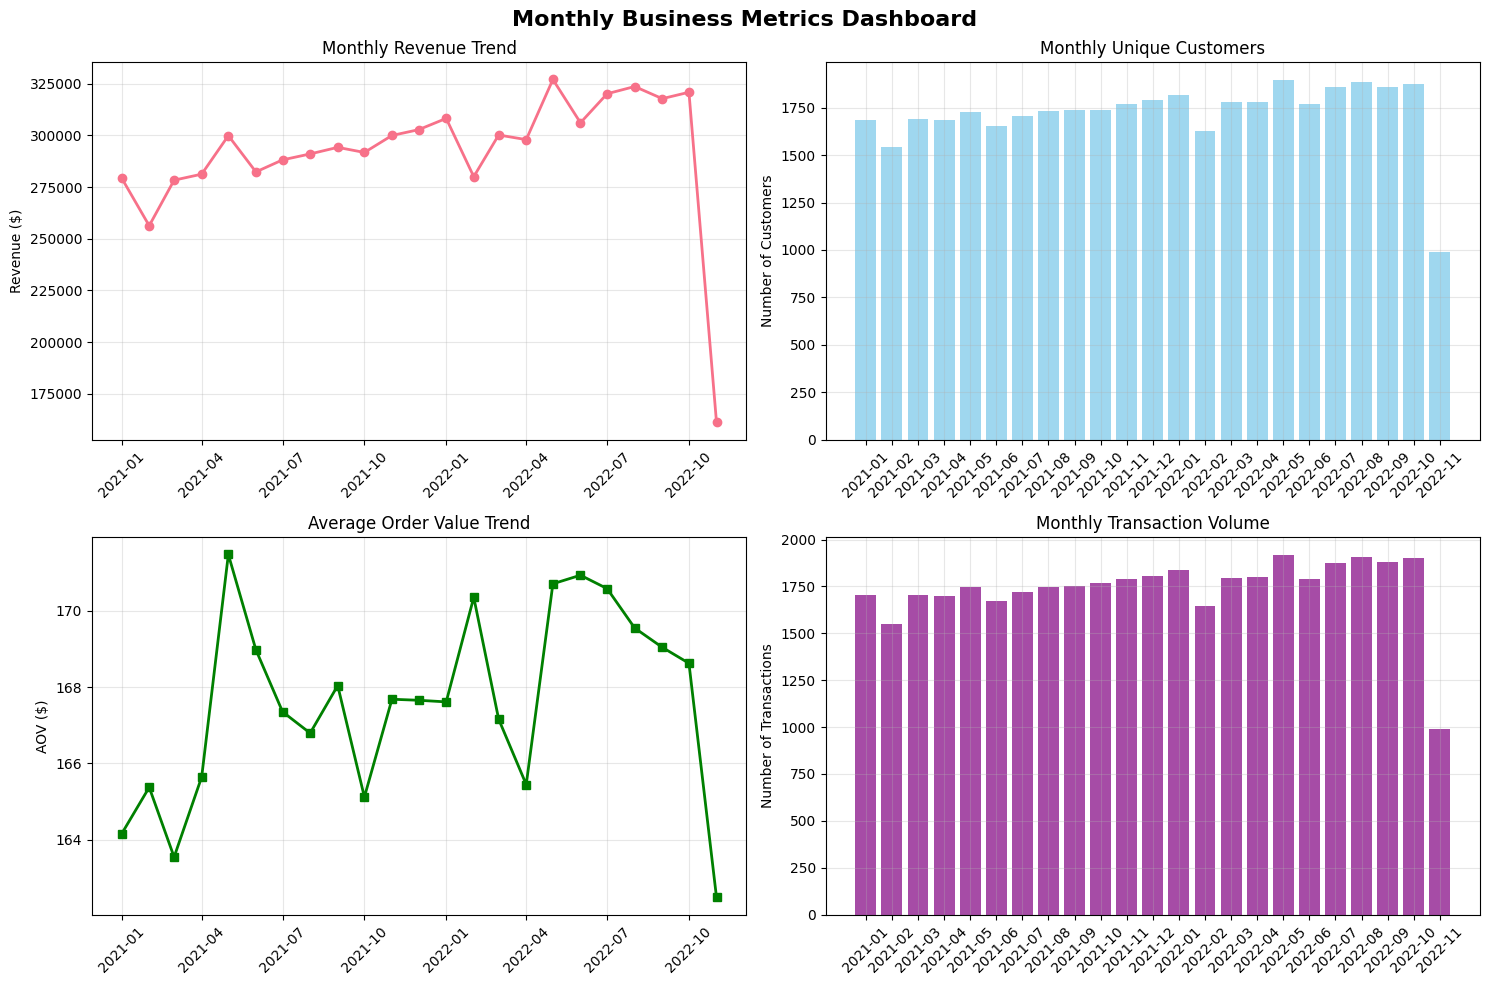


📊 Key Performance Indicators:
   • Total Revenue: $6,709,020.43
   • Average Monthly Revenue: $291,696.54
   • Average Order Value: $167.58
   • Total Transactions: 40,000
   • Peak Revenue Month: 2022-05
   • Average Monthly Customers: 1,722


In [23]:
# Load monthly metrics
monthly_metrics = pd.read_sql_query("""
    SELECT 
        period_month,
        total_sales as total_revenue,
        total_transactions,
        unique_customers,
        avg_order_value,
        0 as new_customers,
        0 as repeat_customers,
        0 as customer_retention_rate
    FROM monthly_metrics 
    ORDER BY period_month
""", business_conn)

# Convert period_month to datetime for better plotting
monthly_metrics['date'] = pd.to_datetime(monthly_metrics['period_month'] + '-01')

print(f"📈 Monthly Metrics Analysis ({len(monthly_metrics)} months)")
print("=" * 50)

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Monthly Business Metrics Dashboard', fontsize=16, fontweight='bold')

# Revenue trend
axes[0,0].plot(monthly_metrics['date'], monthly_metrics['total_revenue'], 
               marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('Monthly Revenue Trend')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Customer acquisition (simplified since we don't have new/repeat breakdown)
axes[0,1].bar(monthly_metrics['period_month'], monthly_metrics['unique_customers'], 
              alpha=0.8, color='skyblue')
axes[0,1].set_title('Monthly Unique Customers')
axes[0,1].set_ylabel('Number of Customers')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Average Order Value
axes[1,0].plot(monthly_metrics['date'], monthly_metrics['avg_order_value'], 
               marker='s', color='green', linewidth=2, markersize=6)
axes[1,0].set_title('Average Order Value Trend')
axes[1,0].set_ylabel('AOV ($)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Transaction Volume
axes[1,1].bar(monthly_metrics['period_month'], monthly_metrics['total_transactions'], 
              color='purple', alpha=0.7)
axes[1,1].set_title('Monthly Transaction Volume')
axes[1,1].set_ylabel('Number of Transactions')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Key Performance Indicators:")
print(f"   • Total Revenue: ${monthly_metrics['total_revenue'].sum():,.2f}")
print(f"   • Average Monthly Revenue: ${monthly_metrics['total_revenue'].mean():,.2f}")
print(f"   • Average Order Value: ${monthly_metrics['avg_order_value'].mean():.2f}")
print(f"   • Total Transactions: {monthly_metrics['total_transactions'].sum():,}")
print(f"   • Peak Revenue Month: {monthly_metrics.loc[monthly_metrics['total_revenue'].idxmax(), 'period_month']}")
print(f"   • Average Monthly Customers: {monthly_metrics['unique_customers'].mean():,.0f}")

## 3. Customer Cohort Analysis

👥 Cohort Analysis (276 cohort-period combinations)


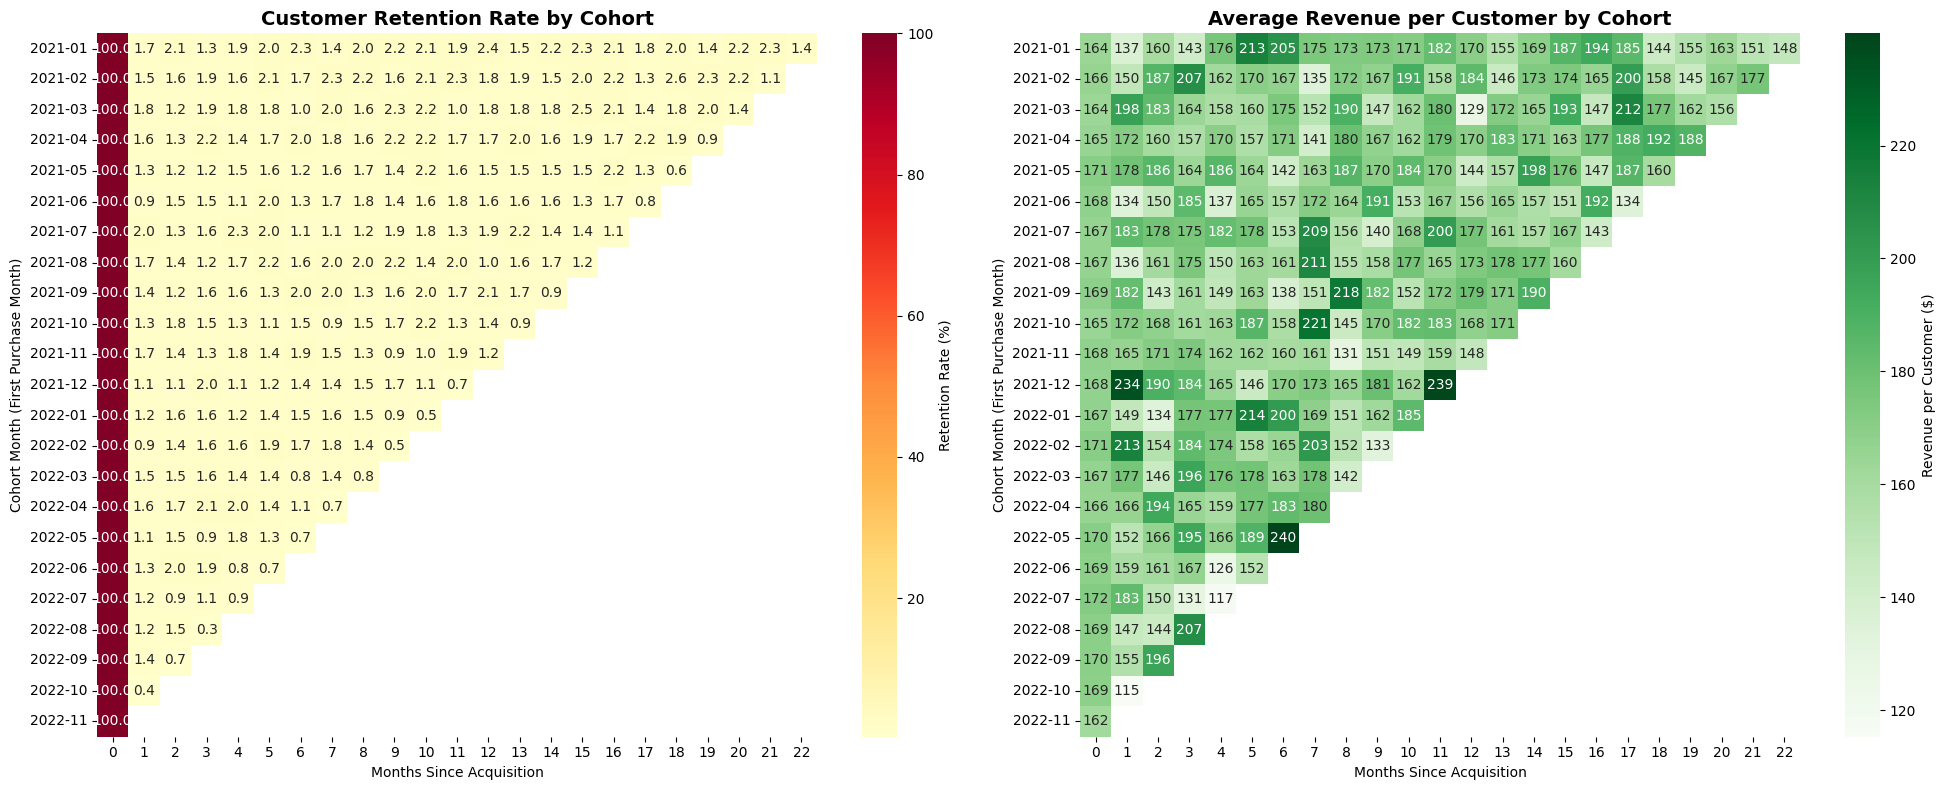


🏆 Top Performing Cohorts:

📈 Best Month-1 Retention:
   • 2021-07: 2.0% retention (31/1537 customers)
   • 2021-03: 1.8% retention (30/1630 customers)
   • 2021-11: 1.7% retention (26/1512 customers)

💰 Highest LTV Cohorts:
   • 2021-01: $405,465.21 total ($240.20 per customer)
   • 2021-03: $368,406.37 total ($226.02 per customer)
   • 2021-04: $362,024.22 total ($225.28 per customer)


In [24]:
# Load cohort analysis data with correct column names
cohort_data = pd.read_sql_query("""
    SELECT 
        cohort_month,
        months_since_acquisition as period_number,
        cohort_size as customers_in_cohort,
        active_customers as customers_returned,
        retention_rate_percent as retention_rate,
        total_sales as cumulative_revenue,
        avg_order_value as avg_revenue_per_customer
    FROM cohort_analysis 
    ORDER BY cohort_month, months_since_acquisition
""", business_conn)

print(f"👥 Cohort Analysis ({len(cohort_data)} cohort-period combinations)")
print("=" * 55)

# Create cohort retention heatmap
cohort_table = cohort_data.pivot_table(index='cohort_month', 
                                        columns='period_number', 
                                        values='retention_rate')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Retention rate heatmap
sns.heatmap(cohort_table, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Retention Rate (%)'})
ax1.set_title('Customer Retention Rate by Cohort', fontsize=14, fontweight='bold')
ax1.set_xlabel('Months Since Acquisition')
ax1.set_ylabel('Cohort Month (First Purchase Month)')

# Revenue per customer heatmap
revenue_table = cohort_data.pivot_table(index='cohort_month', 
                                         columns='period_number', 
                                         values='avg_revenue_per_customer')

sns.heatmap(revenue_table, annot=True, fmt='.0f', cmap='Greens', ax=ax2, cbar_kws={'label': 'Revenue per Customer ($)'})
ax2.set_title('Average Revenue per Customer by Cohort', fontsize=14, fontweight='bold')
ax2.set_xlabel('Months Since Acquisition')
ax2.set_ylabel('Cohort Month (First Purchase Month)')

plt.tight_layout()
plt.show()

# Best performing cohorts
print("\n🏆 Top Performing Cohorts:")

# Best Month 1 retention
month1_retention = cohort_data[cohort_data['period_number'] == 1].nlargest(3, 'retention_rate')
print("\n📈 Best Month-1 Retention:")
for _, row in month1_retention.iterrows():
    print(f"   • {row['cohort_month']}: {row['retention_rate']:.1f}% retention ({row['customers_returned']}/{row['customers_in_cohort']} customers)")

# Highest LTV cohorts (by total revenue)
ltv_cohorts = cohort_data.groupby('cohort_month')['cumulative_revenue'].sum().nlargest(3)
print("\n💰 Highest LTV Cohorts:")
for cohort, revenue in ltv_cohorts.items():
    cohort_size = cohort_data[cohort_data['cohort_month'] == cohort]['customers_in_cohort'].iloc[0]
    print(f"   • {cohort}: ${revenue:,.2f} total (${revenue/cohort_size:.2f} per customer)")

## 4. Customer Lifetime Value Analysis

💎 Customer LTV Analysis (33,477 customers)


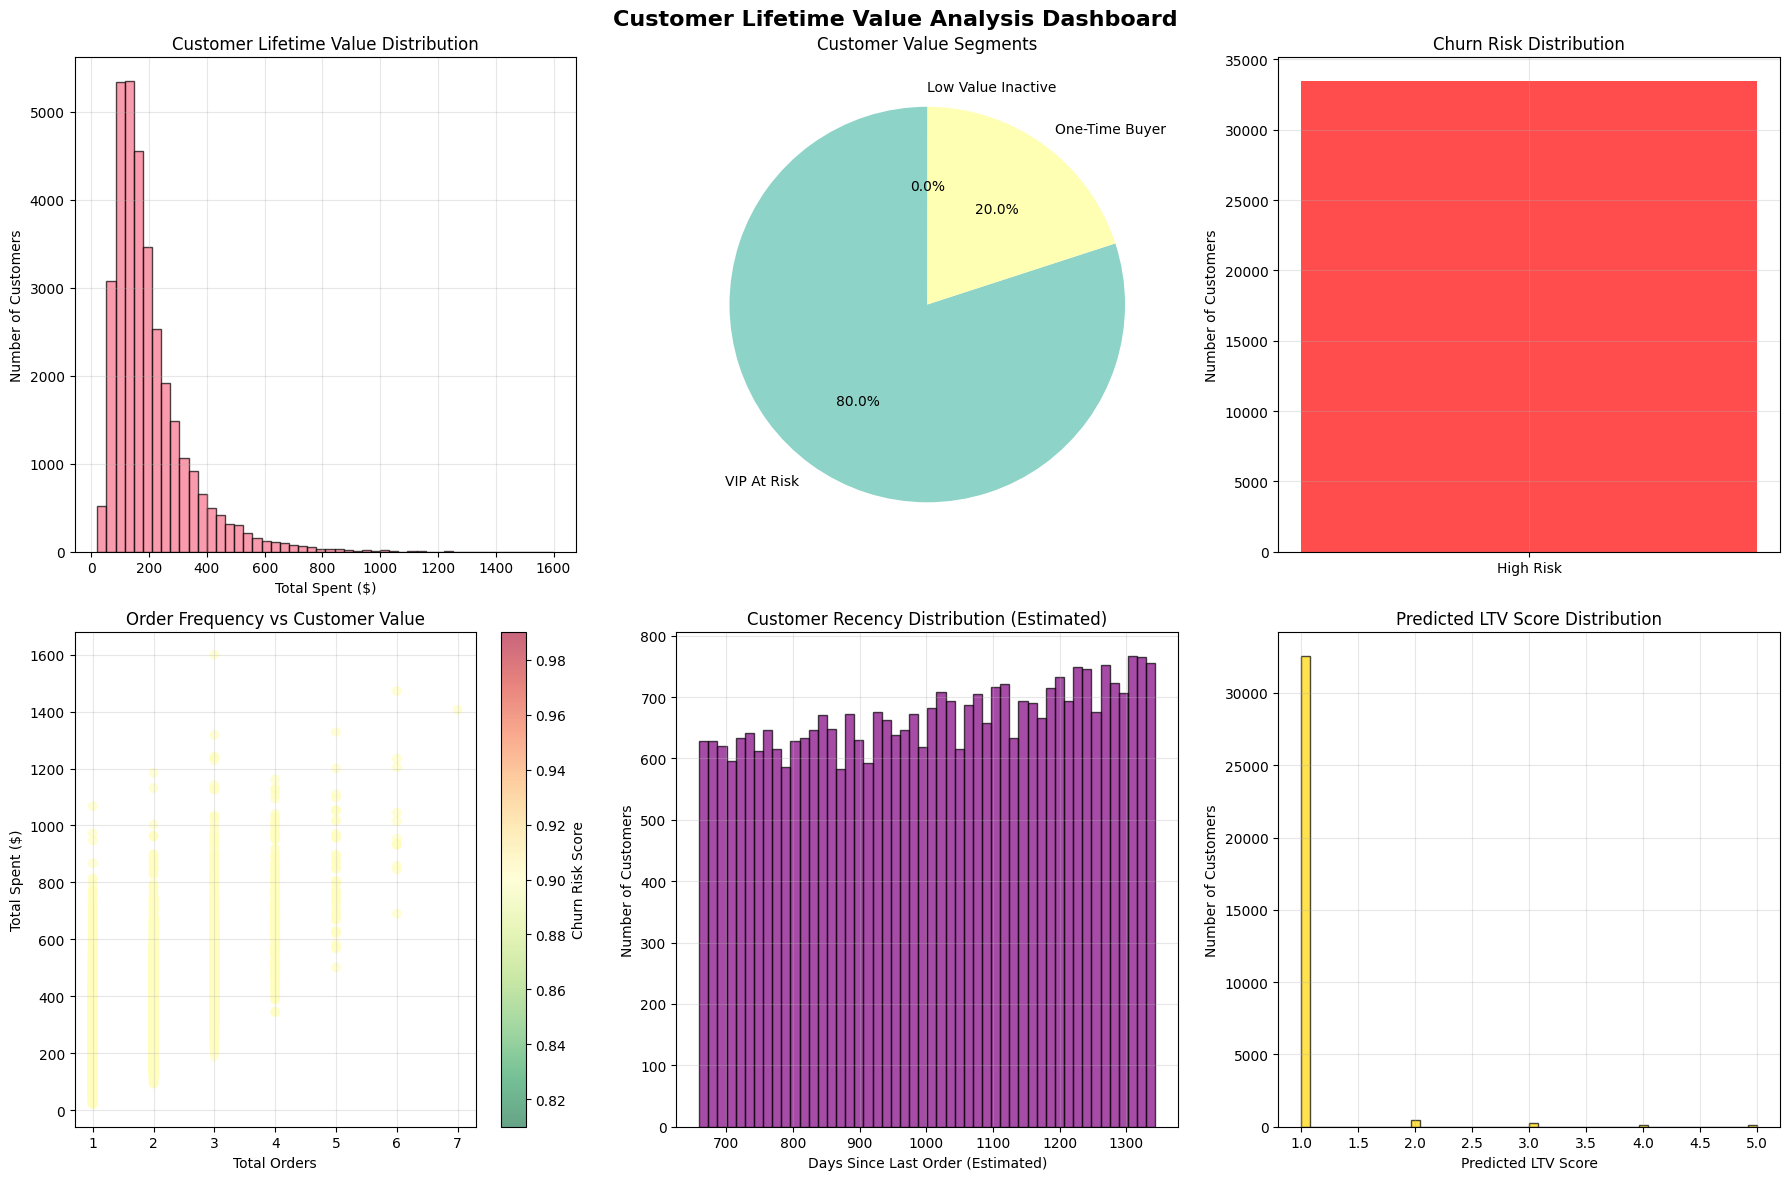


💡 Customer LTV Insights:
   • Average Customer LTV: $200.41
   • Median Customer LTV: $162.95
   • Top 10% Customer LTV: $364.12
   • High-Risk Customers: 33,477 (100.0%)

📊 Customer Segment Analysis:
   • Low Value Inactive: 4 customers, $94.99 avg LTV, 2.0 avg orders
   • One-Time Buyer: 6,691 customers, $79.27 avg LTV, 1.0 avg orders
   • VIP At Risk: 26,782 customers, $230.69 avg LTV, 1.2 avg orders


In [25]:
# Load customer LTV analysis with correct column names
customer_ltv = pd.read_sql_query("""
    SELECT 
        customer_id,
        total_orders,
        total_spent,
        avg_order_value,
        days_active as days_since_first_order,
        CASE 
            WHEN days_active > 365 THEN days_active - 365 
            ELSE 0 
        END as days_since_last_order,
        churn_risk_score,
        predicted_ltv_score,
        customer_segment as customer_value_segment,
        customer_segment as activity_segment,
        CASE 
            WHEN churn_risk_score >= 0.7 THEN 'High Risk'
            WHEN churn_risk_score >= 0.4 THEN 'Medium Risk'
            ELSE 'Low Risk'
        END as churn_risk_category
    FROM customer_ltv_analysis
""", business_conn)

print(f"💎 Customer LTV Analysis ({len(customer_ltv):,} customers)")
print("=" * 55)

# Create LTV analysis dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Customer Lifetime Value Analysis Dashboard', fontsize=16, fontweight='bold')

# Customer Value Distribution
axes[0,0].hist(customer_ltv['total_spent'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Customer Lifetime Value Distribution')
axes[0,0].set_xlabel('Total Spent ($)')
axes[0,0].set_ylabel('Number of Customers')
axes[0,0].grid(True, alpha=0.3)

# Customer Segmentation
segment_counts = customer_ltv['customer_value_segment'].value_counts()
colors = plt.cm.Set3(np.arange(len(segment_counts)))
wedges, texts, autotexts = axes[0,1].pie(segment_counts.values, labels=segment_counts.index, 
                                          autopct='%1.1f%%', colors=colors, startangle=90)
axes[0,1].set_title('Customer Value Segments')

# Churn Risk Distribution
churn_counts = customer_ltv['churn_risk_category'].value_counts()
churn_colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}
bars = axes[0,2].bar(churn_counts.index, churn_counts.values, 
                     color=[churn_colors.get(x, 'gray') for x in churn_counts.index], alpha=0.7)
axes[0,2].set_title('Churn Risk Distribution')
axes[0,2].set_ylabel('Number of Customers')
axes[0,2].grid(True, alpha=0.3)

# Order Frequency vs Value
scatter = axes[1,0].scatter(customer_ltv['total_orders'], customer_ltv['total_spent'], 
                           c=customer_ltv['churn_risk_score'], cmap='RdYlGn_r', alpha=0.6)
axes[1,0].set_title('Order Frequency vs Customer Value')
axes[1,0].set_xlabel('Total Orders')
axes[1,0].set_ylabel('Total Spent ($)')
plt.colorbar(scatter, ax=axes[1,0], label='Churn Risk Score')
axes[1,0].grid(True, alpha=0.3)

# Days Since Last Order (Recency) - use a proxy calculation
axes[1,1].hist(customer_ltv['days_since_last_order'], bins=50, alpha=0.7, 
               color='purple', edgecolor='black')
axes[1,1].set_title('Customer Recency Distribution (Estimated)')
axes[1,1].set_xlabel('Days Since Last Order (Estimated)')
axes[1,1].set_ylabel('Number of Customers')
axes[1,1].grid(True, alpha=0.3)

# LTV Prediction Distribution
axes[1,2].hist(customer_ltv['predicted_ltv_score'], bins=50, alpha=0.7, 
               color='gold', edgecolor='black')
axes[1,2].set_title('Predicted LTV Score Distribution')
axes[1,2].set_xlabel('Predicted LTV Score')
axes[1,2].set_ylabel('Number of Customers')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key LTV insights
print("\n💡 Customer LTV Insights:")
print(f"   • Average Customer LTV: ${customer_ltv['total_spent'].mean():.2f}")
print(f"   • Median Customer LTV: ${customer_ltv['total_spent'].median():.2f}")
print(f"   • Top 10% Customer LTV: ${customer_ltv['total_spent'].quantile(0.9):.2f}")
print(f"   • High-Risk Customers: {len(customer_ltv[customer_ltv['churn_risk_category'] == 'High Risk']):,} ({len(customer_ltv[customer_ltv['churn_risk_category'] == 'High Risk'])/len(customer_ltv)*100:.1f}%)")

# Segment analysis
print("\n📊 Customer Segment Analysis:")
segment_analysis = customer_ltv.groupby('customer_value_segment').agg({
    'customer_id': 'count',
    'total_spent': ['mean', 'sum'],
    'avg_order_value': 'mean',
    'total_orders': 'mean'
}).round(2)

segment_analysis.columns = ['Count', 'Avg_LTV', 'Total_Revenue', 'Avg_AOV', 'Avg_Orders']
for segment, row in segment_analysis.iterrows():
    print(f"   • {segment}: {int(row['Count']):,} customers, ${row['Avg_LTV']:.2f} avg LTV, {row['Avg_Orders']:.1f} avg orders")

## 5. Campaign Targeting Analysis

In [ ]:
# Load campaign targeting data with correct column names
campaign_targets = pd.read_sql_query("""
    SELECT 
        customer_id,
        campaign_type,
        priority_level,
        estimated_value,
        0 as churn_risk_score,  -- Not available in this table
        0 as predicted_ltv_score,  -- Not available in this table
        days_since_last_order,
        recommended_action,
        created_at as created_date
    FROM campaign_targets
    WHERE campaign_type IS NOT NULL
""", business_conn)

print(f"🎯 Campaign Targeting Analysis ({len(campaign_targets):,} customers ready for campaigns)")
print("=" * 70)

if len(campaign_targets) > 0:
    # Create campaign analysis dashboard
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Marketing Campaign Targeting Dashboard', fontsize=16, fontweight='bold')

    # Campaign type distribution
    campaign_counts = campaign_targets['campaign_type'].value_counts()
    bars1 = axes[0,0].bar(range(len(campaign_counts)), campaign_counts.values, 
                          color='skyblue', alpha=0.7, edgecolor='black')
    axes[0,0].set_title('Campaign Type Distribution')
    axes[0,0].set_xticks(range(len(campaign_counts)))
    axes[0,0].set_xticklabels(campaign_counts.index, rotation=45, ha='right')
    axes[0,0].set_ylabel('Number of Customers')
    axes[0,0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{int(height):,}', ha='center', va='bottom')

    # Priority level distribution
    priority_counts = campaign_targets['priority_level'].value_counts().sort_index()
    colors_priority = ['red', 'orange', 'yellow', 'lightgreen', 'green']
    bars2 = axes[0,1].bar(priority_counts.index, priority_counts.values, 
                          color=colors_priority[:len(priority_counts)], alpha=0.7, edgecolor='black')
    axes[0,1].set_title('Campaign Priority Distribution')
    axes[0,1].set_xlabel('Priority Level (1=Highest, 5=Lowest)')
    axes[0,1].set_ylabel('Number of Customers')
    axes[0,1].grid(True, alpha=0.3)

    # Estimated value by campaign type
    value_by_campaign = campaign_targets.groupby('campaign_type')['estimated_value'].sum().sort_values(ascending=True)
    bars3 = axes[1,0].barh(range(len(value_by_campaign)), value_by_campaign.values, 
                           color='lightcoral', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Total Estimated Value by Campaign Type')
    axes[1,0].set_yticks(range(len(value_by_campaign)))
    axes[1,0].set_yticklabels(value_by_campaign.index)
    axes[1,0].set_xlabel('Total Estimated Value ($)')
    axes[1,0].grid(True, alpha=0.3)

    # Days since last order distribution
    axes[1,1].hist(campaign_targets['days_since_last_order'], bins=30, 
                   alpha=0.7, color='mediumpurple', edgecolor='black')
    axes[1,1].set_title('Days Since Last Order (Campaign Targets)')
    axes[1,1].set_xlabel('Days Since Last Order')
    axes[1,1].set_ylabel('Number of Customers')
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Campaign summary statistics
    print("\n🎯 Campaign Targeting Summary:")
    print(f"   • Total Customers Ready: {len(campaign_targets):,}")
    print(f"   • Total Estimated Value: ${campaign_targets['estimated_value'].sum():,.2f}")
    print(f"   • Average Value per Target: ${campaign_targets['estimated_value'].mean():.2f}")
    print(f"   • High Priority Targets (Level 1-2): {len(campaign_targets[campaign_targets['priority_level'] <= 2]):,}")

    print("\n📧 Campaign Type Breakdown:")
    campaign_summary = campaign_targets.groupby('campaign_type').agg({
        'customer_id': 'count',
        'estimated_value': ['sum', 'mean'],
        'priority_level': 'mean',
        'days_since_last_order': 'mean'
    }).round(2)

    campaign_summary.columns = ['Count', 'Total_Value', 'Avg_Value', 'Avg_Priority', 'Avg_Days_Since']
    for campaign, row in campaign_summary.iterrows():
        print(f"   • {campaign}: {int(row['Count']):,} customers, ${row['Total_Value']:,.2f} total value, Priority {row['Avg_Priority']:.1f}")

    print("\n💡 Recommended Actions:")
    action_counts = campaign_targets['recommended_action'].value_counts()
    for action, count in action_counts.items():
        print(f"   • {action}: {count:,} customers")

else:
    print("⚠️  No campaign targets found. This could mean:")
    print("   • All customers are too recent (< 14 days since last order)")
    print("   • Campaign logic needs adjustment for this dataset")
    print("   • Pipeline needs to be re-run with updated parameters")

## 6. Business Insights and Recommendations

💡 Business Insights & Recommendations (3 insights)

🔴 **High-Value Customers at Risk** (Priority 1)
   📋 Category: CHURN_RISK
   📊 Description: 235 high-LTV customers are at risk, representing $100,461.09 in potential lost revenue
   📈 Metric Value: 235.00
   💡 Recommendation: Immediate intervention with personalized offers for high-LTV at-risk customers
   📅 Generated: 2025-09-05 11:41:55
------------------------------------------------------------

🔴 **Customer Conversion Rate** (Priority 1)
   📋 Category: CONVERSION
   📊 Description: Out of 33,477 customers, 28,753 (85.89%) are one-time buyers
   📈 Metric Value: 85.89
   💡 Recommendation: Implement automated email sequences to convert one-time buyers
   📅 Generated: 2025-09-05 11:41:55
------------------------------------------------------------

🟠 **Best Performing Cohort** (Priority 2)
   📋 Category: COHORT
   📊 Description: Cohort 2021-07 has the highest month-1 retention at 2.0%
   📈 Metric Value: 2.02
   💡 Recommendation: Analy

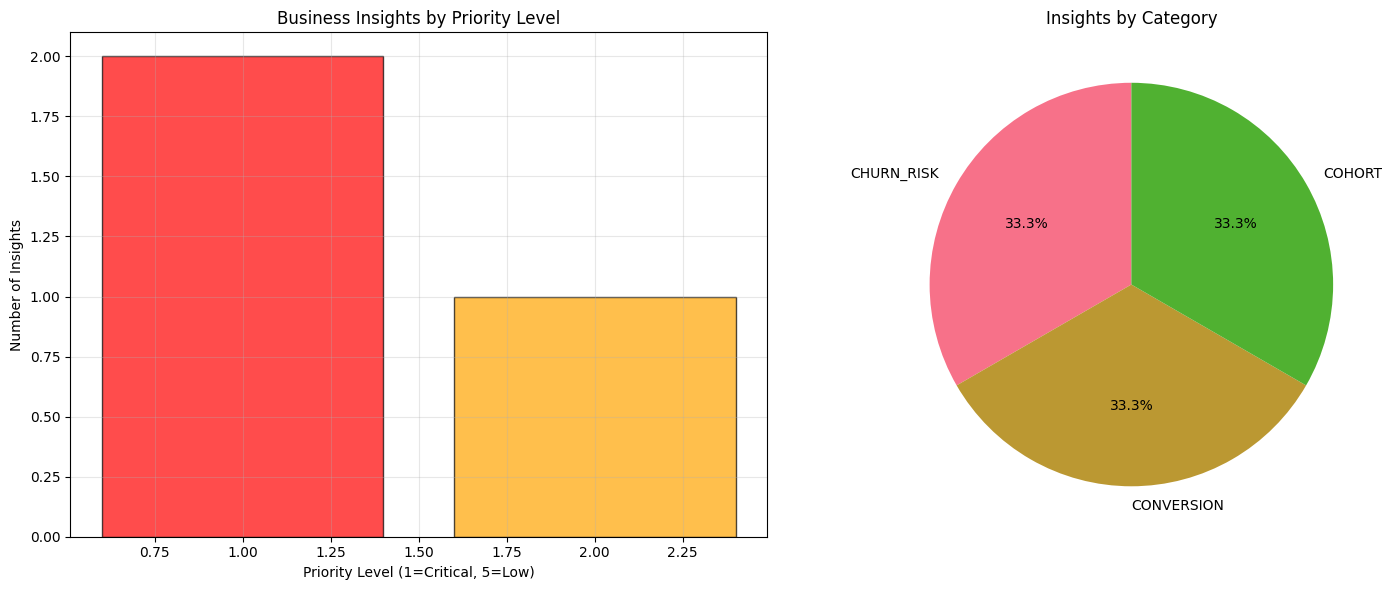


📊 Insights Summary:
   • Total Insights Generated: 3
   • High Priority (1-2): 3
   • Medium Priority (3): 0
   • Low Priority (4-5): 0

📂 Categories:
   • CHURN_RISK: 1 insight
   • CONVERSION: 1 insight
   • COHORT: 1 insight


In [27]:
# Load business insights with correct column names
business_insights = pd.read_sql_query("""
    SELECT 
        insight_id,
        insight_title,
        insight_description,
        insight_type as insight_category,
        metric_value,
        priority_level,
        recommendation,
        created_at as created_date
    FROM business_insights
    ORDER BY priority_level ASC, metric_value DESC
""", business_conn)

print(f"💡 Business Insights & Recommendations ({len(business_insights)} insights)")
print("=" * 65)

if len(business_insights) > 0:
    # Display insights by priority
    priority_colors = {1: '🔴', 2: '🟠', 3: '🟡', 4: '🟢', 5: '🔵'}
    
    for _, insight in business_insights.iterrows():
        priority_icon = priority_colors.get(insight['priority_level'], '⚪')
        
        print(f"\n{priority_icon} **{insight['insight_title']}** (Priority {insight['priority_level']})")
        print(f"   📋 Category: {insight['insight_category']}")
        print(f"   📊 Description: {insight['insight_description']}")
        if pd.notna(insight['metric_value']) and insight['metric_value'] != 0:
            print(f"   📈 Metric Value: {insight['metric_value']:,.2f}")
        print(f"   💡 Recommendation: {insight['recommendation']}")
        print(f"   📅 Generated: {insight['created_date']}")
        print("-" * 60)
    
    # Insights summary visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Priority distribution
    priority_counts = business_insights['priority_level'].value_counts().sort_index()
    colors = ['red', 'orange', 'gold', 'lightgreen', 'lightblue']
    bars = ax1.bar(priority_counts.index, priority_counts.values, 
                   color=colors[:len(priority_counts)], alpha=0.7, edgecolor='black')
    ax1.set_title('Business Insights by Priority Level')
    ax1.set_xlabel('Priority Level (1=Critical, 5=Low)')
    ax1.set_ylabel('Number of Insights')
    ax1.grid(True, alpha=0.3)
    
    # Category distribution
    category_counts = business_insights['insight_category'].value_counts()
    wedges, texts, autotexts = ax2.pie(category_counts.values, labels=category_counts.index, 
                                        autopct='%1.1f%%', startangle=90)
    ax2.set_title('Insights by Category')
    
    plt.tight_layout()
    plt.show()
    
    # Key metrics summary
    print(f"\n📊 Insights Summary:")
    print(f"   • Total Insights Generated: {len(business_insights)}")
    print(f"   • High Priority (1-2): {len(business_insights[business_insights['priority_level'] <= 2])}")
    print(f"   • Medium Priority (3): {len(business_insights[business_insights['priority_level'] == 3])}")
    print(f"   • Low Priority (4-5): {len(business_insights[business_insights['priority_level'] >= 4])}")
    
    categories = business_insights['insight_category'].value_counts()
    print(f"\n📂 Categories:")
    for category, count in categories.items():
        print(f"   • {category}: {count} insight{'s' if count != 1 else ''}")
        
else:
    print("⚠️  No business insights found. Make sure the pipeline completed successfully.")

## 7. Executive Summary Dashboard

📈 EXECUTIVE SUMMARY DASHBOARD


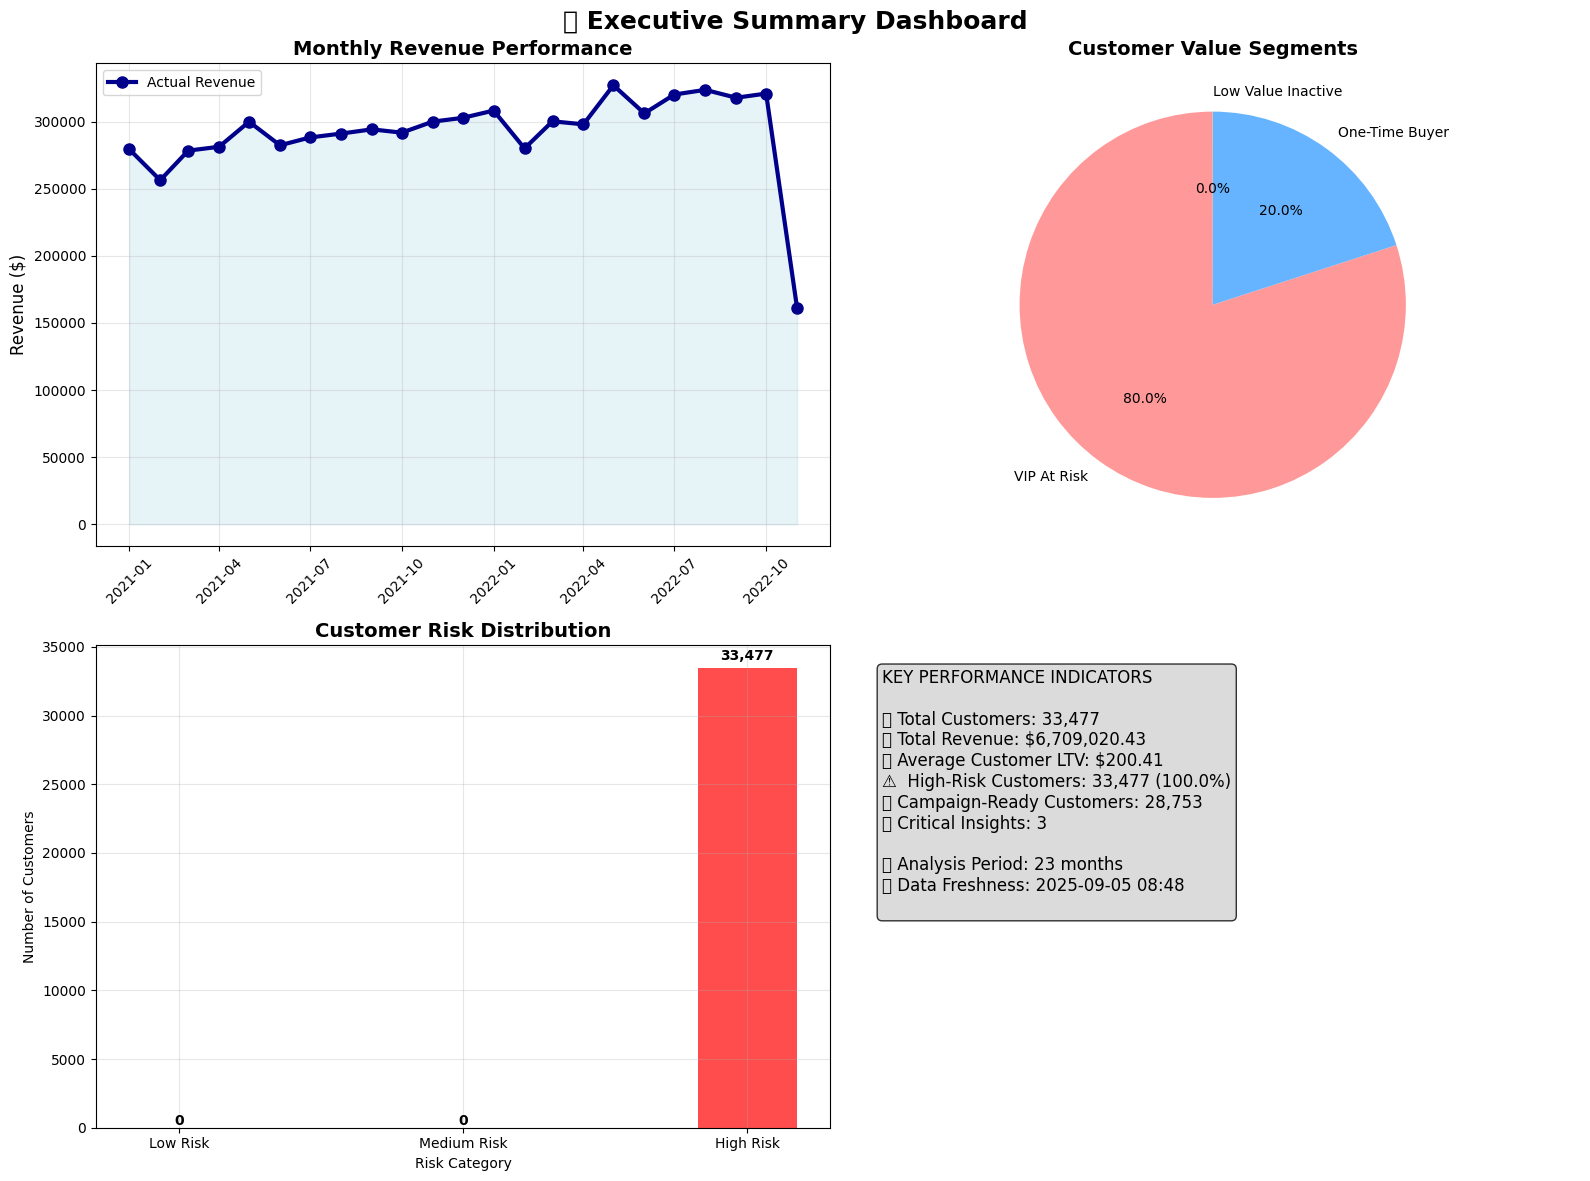


🎯 KEY ACTIONABLE INSIGHTS:

   1. High-Value Customers at Risk
      → Immediate intervention with personalized offers for high-LTV at-risk customers

   2. Customer Conversion Rate
      → Implement automated email sequences to convert one-time buyers

   3. Best Performing Cohort
      → Analyze and replicate the acquisition strategies used for this cohort

💡 IMMEDIATE RECOMMENDATIONS:
   • Focus on 33,477 high-risk customers (potential revenue loss)
   • Execute campaigns for 28,753 ready customers
   • Investigate top-performing cohorts for replication strategies
   • Address 3 critical business issues

✅ Analysis complete - database connection closed


In [28]:
# Create executive summary with key metrics from all tables
print("📈 EXECUTIVE SUMMARY DASHBOARD")
print("=" * 50)

try:
    # Key business metrics
    total_customers = len(customer_ltv)
    total_revenue = monthly_metrics['total_revenue'].sum()
    avg_ltv = customer_ltv['total_spent'].mean()
    high_risk_customers = len(customer_ltv[customer_ltv['churn_risk_category'] == 'High Risk'])
    campaign_ready = len(campaign_targets) if len(campaign_targets) > 0 else 0
    high_priority_insights = len(business_insights[business_insights['priority_level'] <= 2])
    
    # Create executive summary visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 Executive Summary Dashboard', fontsize=18, fontweight='bold')
    
    # Revenue trend with forecast
    ax1.plot(monthly_metrics['date'], monthly_metrics['total_revenue'], 
             marker='o', linewidth=3, markersize=8, color='darkblue', label='Actual Revenue')
    ax1.fill_between(monthly_metrics['date'], monthly_metrics['total_revenue'], 
                     alpha=0.3, color='lightblue')
    ax1.set_title('Monthly Revenue Performance', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Revenue ($)', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Customer segments pie chart
    segment_data = customer_ltv['customer_value_segment'].value_counts()
    colors_segments = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
    wedges, texts, autotexts = ax2.pie(segment_data.values, labels=segment_data.index, 
                                       autopct='%1.1f%%', colors=colors_segments[:len(segment_data)], 
                                       startangle=90, textprops={'fontsize': 10})
    ax2.set_title('Customer Value Segments', fontsize=14, fontweight='bold')
    
    # Churn risk vs Campaign readiness
    risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
    risk_counts = [len(customer_ltv[customer_ltv['churn_risk_category'] == cat]) for cat in risk_categories]
    
    x = np.arange(len(risk_categories))
    width = 0.35
    
    bars1 = ax3.bar(x, risk_counts, width, label='Total Customers', 
                    color=['green', 'orange', 'red'], alpha=0.7)
    ax3.set_title('Customer Risk Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Risk Category')
    ax3.set_ylabel('Number of Customers')
    ax3.set_xticks(x)
    ax3.set_xticklabels(risk_categories)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
    
    # Key metrics summary as text
    ax4.axis('off')
    summary_text = f"""KEY PERFORMANCE INDICATORS
    
👥 Total Customers: {total_customers:,}
💰 Total Revenue: ${total_revenue:,.2f}
💎 Average Customer LTV: ${avg_ltv:.2f}
⚠️  High-Risk Customers: {high_risk_customers:,} ({high_risk_customers/total_customers*100:.1f}%)
🎯 Campaign-Ready Customers: {campaign_ready:,}
🚨 Critical Insights: {high_priority_insights}

📅 Analysis Period: {len(monthly_metrics)} months
📊 Data Freshness: {datetime.now().strftime('%Y-%m-%d %H:%M')}
    """
    
    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print executive summary
    print(f"\n🎯 KEY ACTIONABLE INSIGHTS:")
    if len(business_insights) > 0:
        top_insights = business_insights.head(3)
        for i, (_, insight) in enumerate(top_insights.iterrows(), 1):
            print(f"\n   {i}. {insight['insight_title']}")
            print(f"      → {insight['recommendation']}")
    
    print(f"\n💡 IMMEDIATE RECOMMENDATIONS:")
    print(f"   • Focus on {high_risk_customers:,} high-risk customers (potential revenue loss)")
    if campaign_ready > 0:
        print(f"   • Execute campaigns for {campaign_ready:,} ready customers")
    print(f"   • Investigate top-performing cohorts for replication strategies")
    print(f"   • Address {high_priority_insights} critical business issues")
    
except Exception as e:
    print(f"❌ Error creating executive summary: {e}")
    print("💡 Make sure all pipeline layers completed successfully")

# Close database connection
business_conn.close()
print("\n✅ Analysis complete - database connection closed")

## 8. Data Export Functions

In [19]:
# Optional: Export key datasets to CSV for further analysis
def export_analysis_data():
    """Export key analysis datasets to CSV files"""
    
    import os
    
    # Create exports directory
    export_dir = '../data/exports'
    os.makedirs(export_dir, exist_ok=True)
    
    # Connect to database
    conn = sqlite3.connect('../data/business.db')
    
    # Export each table
    tables_to_export = [
        'monthly_metrics',
        'cohort_analysis', 
        'customer_ltv_analysis',
        'campaign_targets',
        'business_insights'
    ]
    
    exported_files = []
    
    for table in tables_to_export:
        try:
            df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
            filename = f"{export_dir}/{table}_{datetime.now().strftime('%Y%m%d')}.csv"
            df.to_csv(filename, index=False)
            exported_files.append(filename)
            print(f"✅ Exported {table}: {len(df):,} rows → {filename}")
        except Exception as e:
            print(f"❌ Failed to export {table}: {e}")
    
    conn.close()
    
    print(f"\n📁 Exported {len(exported_files)} files to {export_dir}/")
    return exported_files

# Uncomment the line below to export data
# export_analysis_data()

print("\n📋 Analysis Functions Available:")
print("   • export_analysis_data(): Export all tables to CSV")
print("   • All analysis data is available in ../data/business.db SQLite database")
print("   • Use SQL queries for custom analysis beyond this notebook")


📋 Analysis Functions Available:
   • export_analysis_data(): Export all tables to CSV
   • All analysis data is available in ../data/business.db SQLite database
   • Use SQL queries for custom analysis beyond this notebook
